In [85]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib

In [86]:
import numpy as np
import pandas as pd

In [14]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect


In [5]:
engine = create_engine('sqlite:///hawaii.sqlite')

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
test = engine.execute("select * from measurement order by date desc limit 10")
for row in test:
    print(row)

(2724, 'USC00519397', '2017-08-23', 0.0, 81.0)
(7635, 'USC00514830', '2017-08-23', 0.0, 82.0)
(12187, 'USC00519523', '2017-08-23', 0.08, 82.0)
(19550, 'USC00516128', '2017-08-23', 0.45, 76.0)
(2723, 'USC00519397', '2017-08-22', 0.0, 82.0)
(12186, 'USC00519523', '2017-08-22', 0.0, 82.0)
(19549, 'USC00516128', '2017-08-22', 0.5, 76.0)
(2722, 'USC00519397', '2017-08-21', 0.0, 81.0)
(7634, 'USC00514830', '2017-08-21', 0.02, 79.0)
(12185, 'USC00519523', '2017-08-21', None, 82.0)


In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

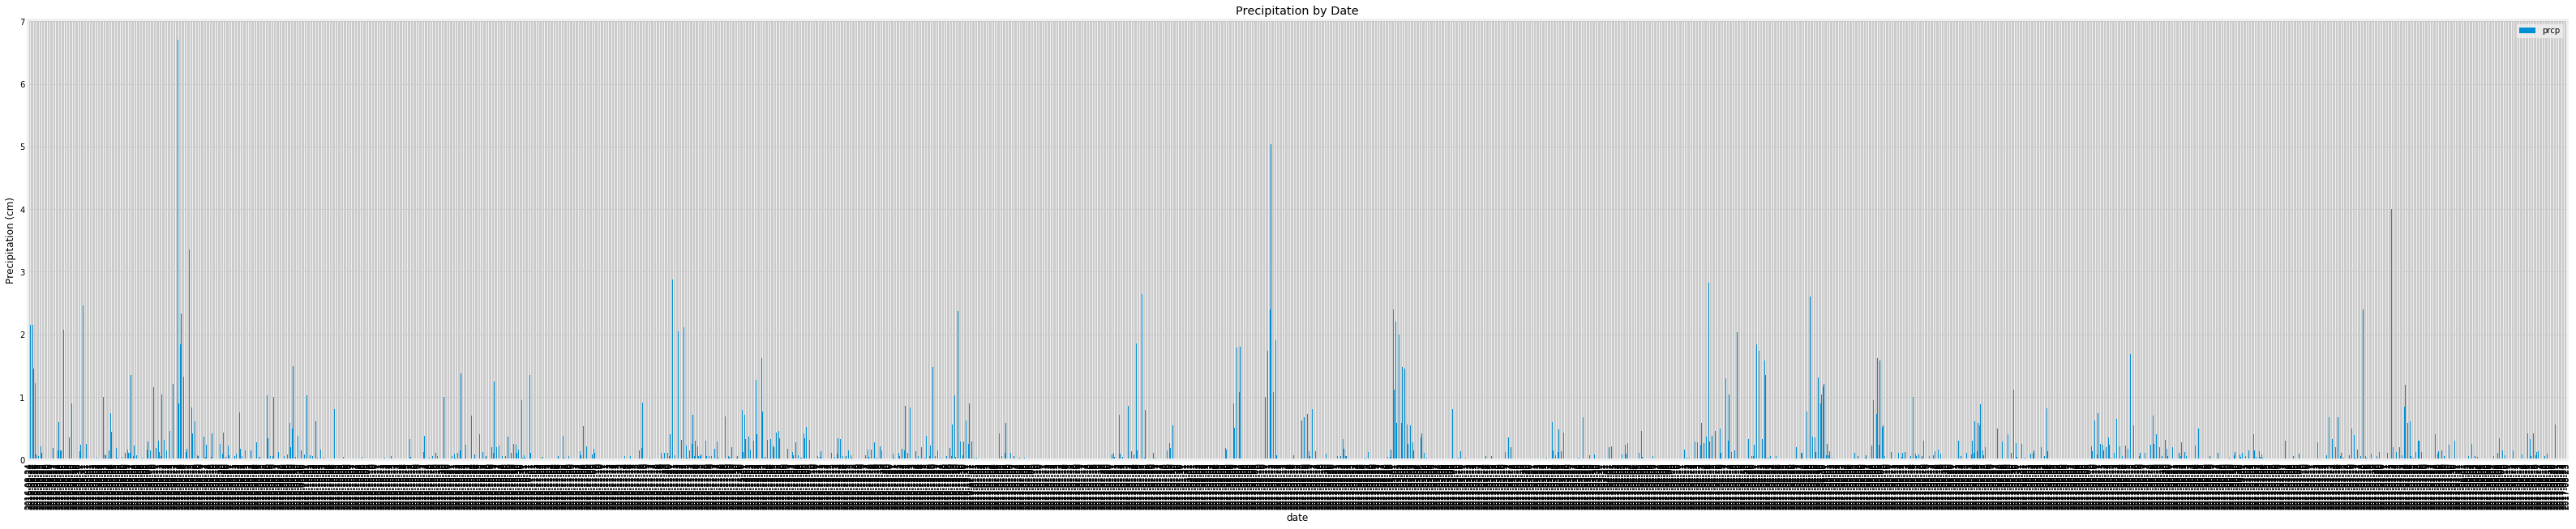

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from today
#latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date = '2017-08-23'
date_converted = datetime.strptime(latest_date, '%Y-%m-%d')
one_year_ago = str(date_converted - dt.timedelta(days=365))
#print(one_year_ago)
# Perform a query to retrieve the data and precipitation scores
data_result = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > one_year_ago)
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.read_sql(data_result.statement,session.bind).set_index("date")
precip_df.head()
# Sort the dataframe by date
precip_sorted = precip_df.sort_values("date")
# Use Pandas Plotting with Matplotlib to plot the data
precip_sorted.plot(kind='bar', figsize=(50,10))
plt.title("Precipitation by Date")
plt.ylabel("Precipitation (cm)")
#for index, label in enumerate(plt.xaxis.get_ticklabels()):
 #   if index % 5 != 0:
  #      label.set_visible(False)
# Rotate the xticks for the dates
plt.xticks(rotation="vertical")
#plt.savefig("precip.png")
plt.show()

![precipitation](Images/precipitation.png)

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [18]:
# How many stations are available in this dataset?
station_result = session.query(Station).group_by(Station.station).count()
station_result

9

In [19]:
# What are the most active stations?
# List the stations and the counts in descending order.
station_count = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
for row in station_count:
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
sel = [func.max(Measurement.tobs),
       func.min(Measurement.tobs),
       func.avg(Measurement.tobs)]
statistics = session.query(*sel).filter(Measurement.station == "USC00519281").all()
print(statistics)


[(85.0, 54.0, 71.66378066378067)]


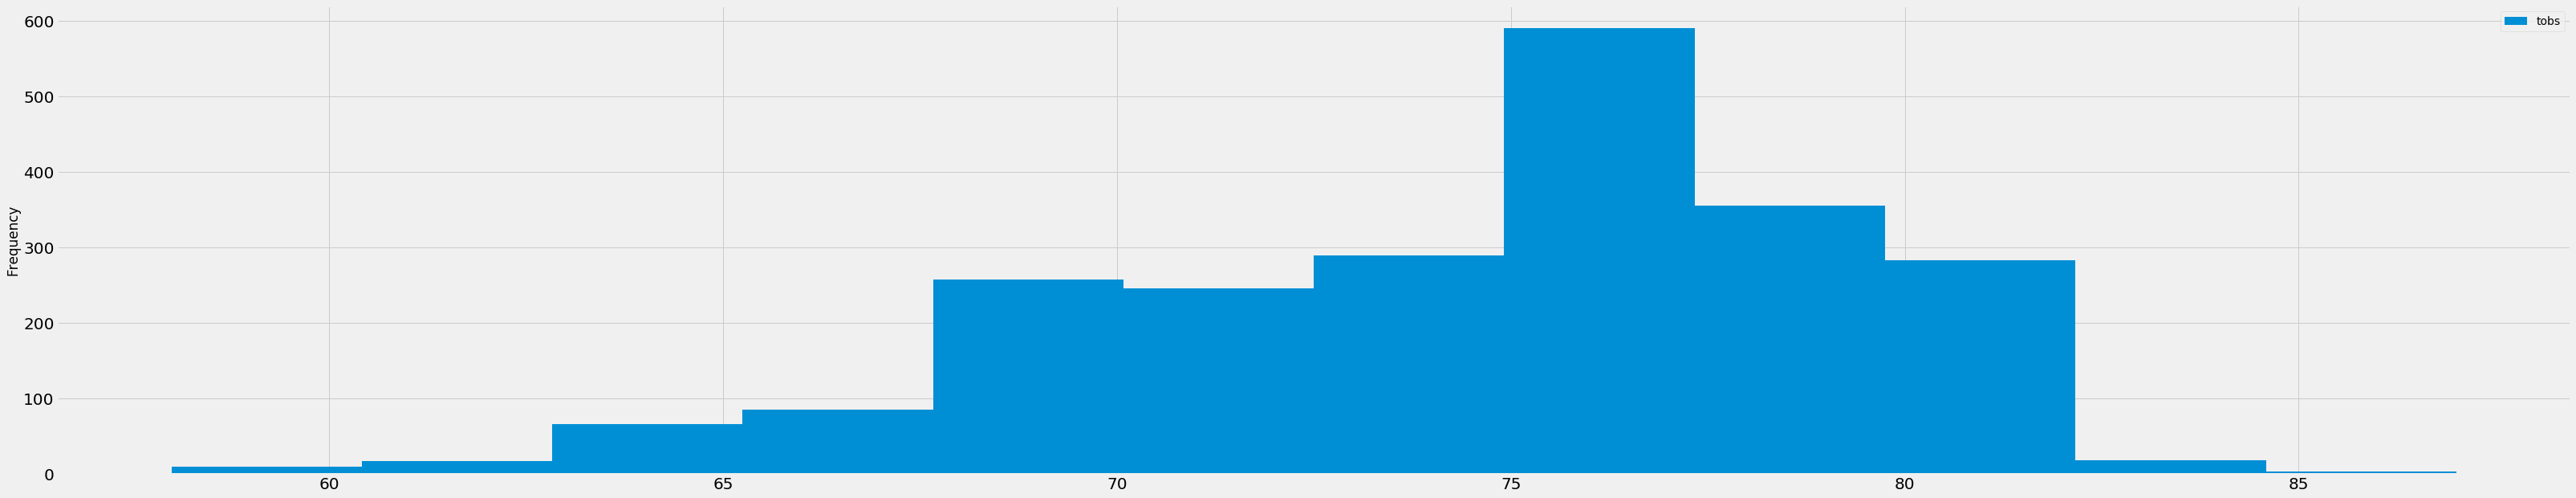

In [88]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
latest_date = '2017-08-23'
date_converted = datetime.strptime(latest_date, '%Y-%m-%d')
one_year_ago = str(date_converted - dt.timedelta(days=365))
station_result = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station==Station.station).filter(Measurement.date > one_year_ago)
temp_df = pd.read_sql(station_result.statement,session.bind).set_index("date")
temp_df.head()
# Sort the dataframe by date
temp_sorted = temp_df.sort_values("date")
# Use Pandas Plotting with Matplotlib to plot the data
temp_sorted.plot(kind='hist', bins=12, figsize=(50,10))
matplotlib.rc('xtick', labelsize=30)
matplotlib.rc('ytick', labelsize=30)

In [22]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

begin_date = '2017-05-15'
end_date = '2017-05-22'
trip_result = (calc_temps(begin_date, end_date))
print(trip_result)

[(68.0, 74.57777777777778, 80.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
begin_one_year_ago = str(datetime.strptime(begin_date, '%Y-%m-%d') - dt.timedelta(days=365))
end_one_year_ago = str(datetime.strptime(end_date, '%Y-%m-%d') - dt.timedelta(days=365))
print(calc_temps(begin_one_year_ago, end_one_year_ago))

[(70.0, 75.93333333333334, 79.0)]


Text(0.5,0,'')

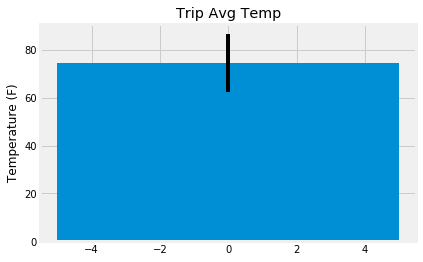

In [29]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
diff = trip_result[0][2]-trip_result[0][0]
plt.bar(0, trip_result[0][1], yerr = diff, width=10)
plt.title("Trip Avg Temp")
plt.ylabel("Temperature (F)")
plt.xlabel("")

In [30]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
station_precip = session.query(func.sum(Measurement.prcp), Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
    filter(Measurement.station==Station.station).filter(Measurement.date >= begin_one_year_ago).\
    filter(Measurement.date <= end_one_year_ago).group_by(Station.station).order_by(func.sum(Measurement.prcp).desc())
for station in station_precip:
    print(station)

(1.8199999999999998, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
(0.61, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
(0.4799999999999999, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
(0.36000000000000004, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
(0.04, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
(0.0, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
(None, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)


## Optional Challenge Assignment

In [48]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("5-15")

[(None, None, None)]

In [62]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
begin_date = '2017-05-15'
end_date = '2017-05-22'
delta = datetime.strptime(end_date, '%Y-%m-%d')-datetime.strptime(begin_date, '%Y-%m-%d')
trip_length = delta.days
#trip_length
# Use the start and end date to create a range of dates
date_range = []
date_range.append(begin_date)
for x in range(trip_length):
    date = str(datetime.date(datetime.strptime(begin_date, '%Y-%m-%d') + dt.timedelta(days=x+1)))
    date_range.append(date)    
#print(date_range)
# Stip off the year and save a list of %m-%d strings
cleaned_date=[]
for date in date_range:
    cleaned = datetime.strptime(date, '%Y-%m-%d')
    cleaned_date.append(f"0{cleaned.month}-{cleaned.day}")
#print(cleaned_date)
# Loop through the list of %m-%d strings and calculate the normals for each date
normals=[]
for date in cleaned_date:
#    print(date)
    results = daily_normals(date)
    temp_results = list(np.ravel(results))
#    print(temp_results)
    normals.append(temp_results)
print(normals)

[[63.0, 73.69090909090909, 79.0], [68.0, 74.37931034482759, 80.0], [68.0, 74.45, 79.0], [68.0, 74.10714285714286, 82.0], [65.0, 73.80701754385964, 79.0], [68.0, 73.89655172413794, 79.0], [64.0, 72.96428571428571, 80.0], [64.0, 74.45614035087719, 80.0]]


In [74]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_df = pd.DataFrame(normals, columns=['Min', 'Avg', 'Max'])
date_df = pd.DataFrame(date_range, columns = ["Trip Dates"])
#date_df
trip_results_df = pd.concat([date_df, trip_df], axis=1).set_index("Trip Dates")
trip_results_df

,Min,Avg,Max
Trip Dates,,,
2017-05-15,63.0,73.690909,79.0
2017-05-16,68.0,74.379310,80.0
2017-05-17,68.0,74.450000,79.0
2017-05-18,68.0,74.107143,82.0
2017-05-19,65.0,73.807018,79.0
2017-05-20,68.0,73.896552,79.0
2017-05-21,64.0,72.964286,80.0
2017-05-22,64.0,74.456140,80.0


AttributeError: 'NoneType' object has no attribute 'update'

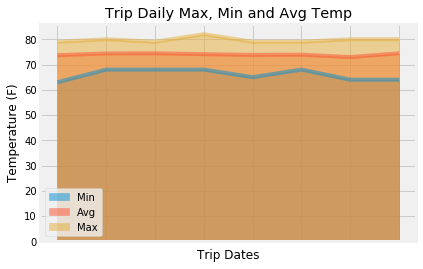

In [81]:
# Plot the daily normals as an area plot with `stacked=False`
trip_results_df.plot(kind='area', stacked=False)
plt.title("Trip Daily Max, Min and Avg Temp")
plt.ylabel("Temperature (F)")
#plt.xticks(date_df, rotation="vertical")